In [1]:
import gcsfs
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pyarrow
import seaborn as sns
import time

from google.cloud import bigquery
from google.cloud import storage
from pyarrow import parquet as pq
from sklearn.linear_model import LinearRegression

In [2]:
def sql2df(project, sql):
    bq = bigquery.Client(project=project)
    df = bq.query(sql).result().to_dataframe()
    return df

# QFF redeem values

In [38]:
qff_redeem = sql2df("gcp-wow-rwds-ai-beh-seg-dev", 
                     """
                     select * from `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.redemption_qff_redeem`
                     where MOD(ABS(FARM_FINGERPRINT(crn)), 90) = 45;
                     """)
qff_redeem_features_type_map = {
    feature: "float64" for feature in ["total_redeem_value", "average_redeem_value", "max_redeem_value", "min_redeem_value"]
}
qff_redeem = qff_redeem.astype(qff_redeem_features_type_map)
qff_redeem.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


total_redeem_value  average_redeem_value  max_redeem_value  \
count        11104.000000          11104.000000      11104.000000   
mean            61.706592             11.379531         16.376081   
std             85.209851              7.526868         30.258387   
min             10.000000             10.000000         10.000000   
25%             10.000000             10.000000         10.000000   
50%             30.000000             10.000000         10.000000   
75%             70.000000             10.000000         10.000000   
max           2650.000000            300.000000       1590.000000   

       min_redeem_value  redeem_times  
count      11104.000000  11104.000000  
mean          10.231448      5.235050  
std            4.652232      6.010308  
min           10.000000      1.000000  
25%           10.000000      1.000000  
50%           10.000000      3.000000  
75%           10.000000      7.000000  
max          300.000000     72.000000

In [39]:
print("total_redeem_value 99%:", np.percentile(qff_redeem.total_redeem_value, [99])[0])
print("average_redeem_value 99%:", np.percentile(qff_redeem.average_redeem_value, [99])[0])
print("max_redeem_value 99%:", np.percentile(qff_redeem.max_redeem_value, [99])[0])
print("min_redeem_value 99%:", np.percentile(qff_redeem.min_redeem_value, [99])[0])
print("redeem_times 99%:", np.percentile(qff_redeem.redeem_times, [99])[0])

uv_total_redeem_value = np.percentile(qff_redeem.total_redeem_value, [99])[0]
uv_average_redeem_value = np.percentile(qff_redeem.average_redeem_value, [99])[0]
uv_max_redeem_value = np.percentile(qff_redeem.max_redeem_value, [99])[0]
uv_min_redeem_value = np.percentile(qff_redeem.min_redeem_value, [99])[0]

total_redeem_value 99%: 389.69999999999345
average_redeem_value 99%: 30.0
max_redeem_value 99%: 100.0
min_redeem_value 99%: 10.0
redeem_times 99%: 28.0


In [40]:
qff_redeem.total_redeem_value[(qff_redeem.total_redeem_value>1.1*uv_total_redeem_value)] = 1.1*uv_total_redeem_value
qff_redeem.average_redeem_value[(qff_redeem.average_redeem_value>1.1*uv_average_redeem_value)] = 1.1*uv_average_redeem_value
qff_redeem.max_redeem_value[(qff_redeem.max_redeem_value>1.1*uv_max_redeem_value)] = 1.1*uv_max_redeem_value
qff_redeem.min_redeem_value[(qff_redeem.min_redeem_value>1.1*uv_min_redeem_value)] = 1.1*uv_min_redeem_value
qff_redeem.describe()

/tmp/ipykernel_145/581678471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qff_redeem.total_redeem_value[(qff_redeem.total_redeem_value>1.1*uv_total_redeem_value)] = 1.1*uv_total_redeem_value
/tmp/ipykernel_145/581678471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qff_redeem.average_redeem_value[(qff_redeem.average_redeem_value>1.1*uv_average_redeem_value)] = 1.1*uv_average_redeem_value
/tmp/ipykernel_145/581678471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

total_redeem_value  average_redeem_value  max_redeem_value  \
count        11104.000000          11104.000000      11104.000000   
mean            60.360435             11.054083         15.219741   
std             72.808262              3.198615         14.183674   
min             10.000000             10.000000         10.000000   
25%             10.000000             10.000000         10.000000   
50%             30.000000             10.000000         10.000000   
75%             70.000000             10.000000         10.000000   
max            428.670000             33.000000        110.000000   

       min_redeem_value  redeem_times  
count      11104.000000  11104.000000  
mean          10.008015      5.235050  
std            0.089172      6.010308  
min           10.000000      1.000000  
25%           10.000000      1.000000  
50%           10.000000      3.000000  
75%           10.000000      7.000000  
max           11.000000     72.000000

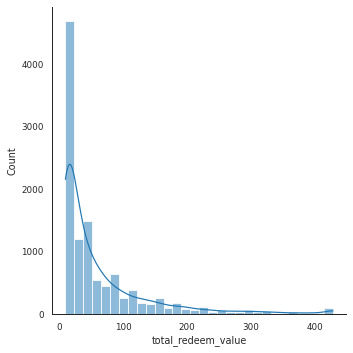

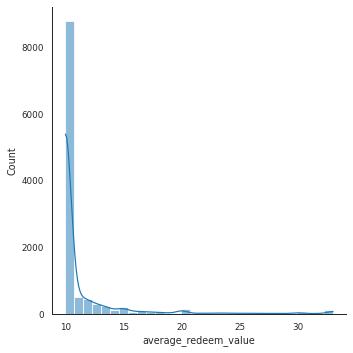

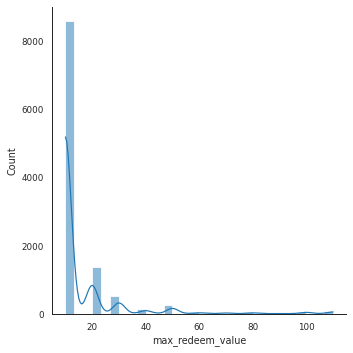

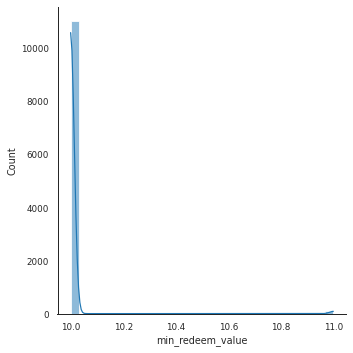

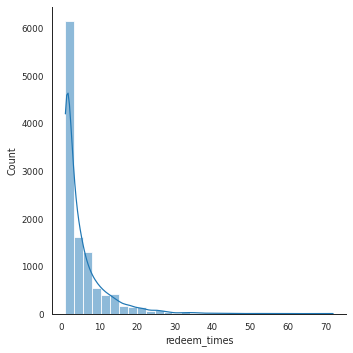

In [14]:
sns.set_context({"figure.figsize":(10,10)})
sns.set_style('white')
sns.set_context("paper")
sns.displot(data=qff_redeem, x="total_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=qff_redeem, x="average_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=qff_redeem, x="max_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=qff_redeem, x="min_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=qff_redeem, x="redeem_times", kind="hist", kde=True, bins=30)

# QFF recency values

In [11]:
qff_recency = sql2df("gcp-wow-rwds-ai-beh-seg-dev", 
                     """
                     select * from `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.redemption_qff_recency`
                     where MOD(ABS(FARM_FINGERPRINT(crn)), 90) = 45;
                     """)
qff_recency.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


recency
count  11104.000000
mean      85.342939
std       85.980953
min        0.000000
25%       18.000000
50%       54.000000
75%      124.000000
max      364.000000

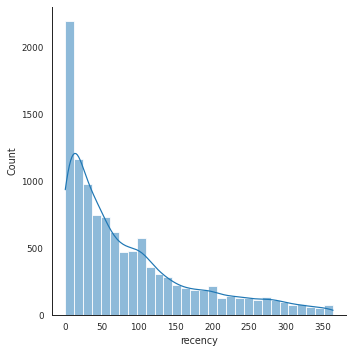

In [13]:
sns.displot(data=qff_recency, x="recency", kind="hist", kde=True, bins=30)

# BFC redeem values

In [28]:
bfc_redeem = sql2df("gcp-wow-rwds-ai-beh-seg-dev", 
                     """
                     select * from `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.redemption_bfc_redeem`
                     where MOD(ABS(FARM_FINGERPRINT(crn)), 30) = 15;
                     """)
bfc_redeem_features_type_map = {
    feature: "float64" for feature in ["total_redeem_value", "average_redeem_value", "max_redeem_value", "min_redeem_value"]
}
bfc_redeem = bfc_redeem.astype(bfc_redeem_features_type_map)
bfc_redeem.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


total_redeem_value  average_redeem_value  max_redeem_value  \
count        12245.000000          12245.000000      12245.000000   
mean           122.532462             62.706227         88.268681   
std            140.367269             62.272963         88.607460   
min             10.000000             10.000000         10.000000   
25%             30.000000             20.000000         20.000000   
50%             80.000000             40.000000         60.000000   
75%            170.000000             85.000000        120.000000   
max           1760.000000            820.000000        860.000000   

       min_redeem_value  redeem_times  
count      12245.000000  12245.000000  
mean          43.589220      2.010698  
std           60.099527      1.582574  
min           10.000000      1.000000  
25%           10.000000      1.000000  
50%           20.000000      1.000000  
75%           50.000000      2.000000  
max          820.000000     19.000000

In [29]:
print("total_redeem_value 99%:", np.percentile(bfc_redeem.total_redeem_value, [99])[0])
print("average_redeem_value 99%:", np.percentile(bfc_redeem.average_redeem_value, [99])[0])
print("max_redeem_value 99%:", np.percentile(bfc_redeem.max_redeem_value, [99])[0])
print("min_redeem_value 99%:", np.percentile(bfc_redeem.min_redeem_value, [99])[0])
print("redeem_times 99%:", np.percentile(bfc_redeem.redeem_times, [99])[0])

uv_total_redeem_value = np.percentile(bfc_redeem.total_redeem_value, [99])[0]
uv_average_redeem_value = np.percentile(bfc_redeem.average_redeem_value, [99])[0]
uv_max_redeem_value = np.percentile(bfc_redeem.max_redeem_value, [99])[0]
uv_min_redeem_value = np.percentile(bfc_redeem.min_redeem_value, [99])[0]

total_redeem_value 99%: 680.0
average_redeem_value 99%: 300.0
max_redeem_value 99%: 400.0
min_redeem_value 99%: 300.0
redeem_times 99%: 8.0


In [30]:
bfc_redeem.total_redeem_value[(bfc_redeem.total_redeem_value>1.1*uv_total_redeem_value)] = 1.1*uv_total_redeem_value
bfc_redeem.average_redeem_value[(bfc_redeem.average_redeem_value>1.1*uv_average_redeem_value)] = 1.1*uv_average_redeem_value
bfc_redeem.max_redeem_value[(bfc_redeem.max_redeem_value>1.1*uv_max_redeem_value)] = 1.1*uv_max_redeem_value
bfc_redeem.min_redeem_value[(bfc_redeem.min_redeem_value>1.1*uv_min_redeem_value)] = 1.1*uv_min_redeem_value
bfc_redeem.describe()

/tmp/ipykernel_145/4192298821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bfc_redeem.total_redeem_value[(bfc_redeem.total_redeem_value>1.1*uv_total_redeem_value)] = 1.1*uv_total_redeem_value
/tmp/ipykernel_145/4192298821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bfc_redeem.average_redeem_value[(bfc_redeem.average_redeem_value>1.1*uv_average_redeem_value)] = 1.1*uv_average_redeem_value
/tmp/ipykernel_145/4192298821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

total_redeem_value  average_redeem_value  max_redeem_value  \
count        12245.000000          12245.000000      12245.000000   
mean           121.078481             62.220315         87.614537   
std            131.605094             59.310870         85.216359   
min             10.000000             10.000000         10.000000   
25%             30.000000             20.000000         20.000000   
50%             80.000000             40.000000         60.000000   
75%            170.000000             85.000000        120.000000   
max            748.000000            330.000000        440.000000   

       min_redeem_value  redeem_times  
count      12245.000000  12245.000000  
mean          43.113924      2.010698  
std           56.917702      1.582574  
min           10.000000      1.000000  
25%           10.000000      1.000000  
50%           20.000000      1.000000  
75%           50.000000      2.000000  
max          330.000000     19.000000

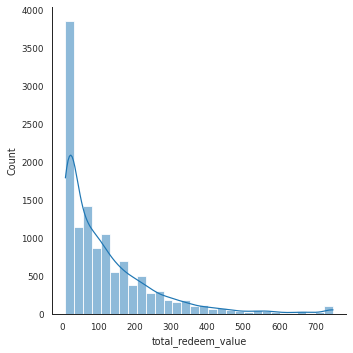

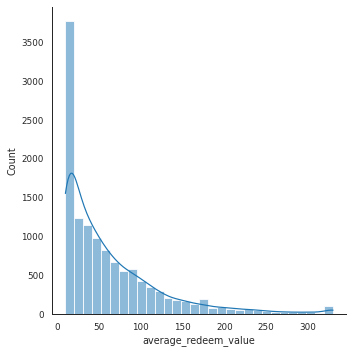

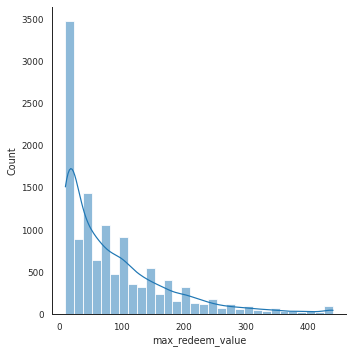

In [31]:
sns.displot(data=bfc_redeem, x="total_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=bfc_redeem, x="average_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=bfc_redeem, x="max_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=bfc_redeem, x="min_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=bfc_redeem, x="redeem_times", kind="hist", kde=True, bins=30)

# VOU redeem values.

In [32]:
vou_redeem = sql2df("gcp-wow-rwds-ai-beh-seg-dev", 
                     """
                     select * from gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.redemption_vou_redeem
                     where MOD(ABS(FARM_FINGERPRINT(crn)), 500) = 250;
                     """)
vou_redeem_features_type_map = {
    feature: "float64" for feature in ["total_redeem_value", "average_redeem_value", "max_redeem_value", "min_redeem_value"]
}
vou_redeem = vou_redeem.astype(vou_redeem_features_type_map)
vou_redeem.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


total_redeem_value  average_redeem_value  max_redeem_value  \
count        10476.000000          10476.000000      10476.000000   
mean            52.764414             13.185401         17.973463   
std             99.164405             14.403354         26.594231   
min             10.000000             10.000000         10.000000   
25%             10.000000             10.000000         10.000000   
50%             30.000000             10.000000         10.000000   
75%             60.000000             10.000000         10.000000   
max           5950.000000            520.000000        520.000000   

       min_redeem_value  redeem_times  
count      10476.000000  10476.000000  
mean          11.423253      3.914853  
std           12.206181      4.504657  
min           10.000000      1.000000  
25%           10.000000      1.000000  
50%           10.000000      2.000000  
75%           10.000000      5.000000  
max          520.000000     90.000000

In [33]:
print("total_redeem_value 99%:", np.percentile(vou_redeem.total_redeem_value, [99])[0])
print("average_redeem_value 99%:", np.percentile(vou_redeem.average_redeem_value, [99])[0])
print("max_redeem_value 99%:", np.percentile(vou_redeem.max_redeem_value, [99])[0])
print("min_redeem_value 99%:", np.percentile(vou_redeem.min_redeem_value, [99])[0])
print("redeem_times 99%:", np.percentile(vou_redeem.redeem_times, [99])[0])

uv_total_redeem_value = np.percentile(vou_redeem.total_redeem_value, [99])[0]
uv_average_redeem_value = np.percentile(vou_redeem.average_redeem_value, [99])[0]
uv_max_redeem_value = np.percentile(vou_redeem.max_redeem_value, [99])[0]
uv_min_redeem_value = np.percentile(vou_redeem.min_redeem_value, [99])[0]

vou_redeem.total_redeem_value[(vou_redeem.total_redeem_value>1.1*uv_total_redeem_value)] = 1.1*uv_total_redeem_value
vou_redeem.average_redeem_value[(vou_redeem.average_redeem_value>1.1*uv_average_redeem_value)] = 1.1*uv_average_redeem_value
vou_redeem.max_redeem_value[(vou_redeem.max_redeem_value>1.1*uv_max_redeem_value)] = 1.1*uv_max_redeem_value
vou_redeem.min_redeem_value[(vou_redeem.min_redeem_value>1.1*uv_min_redeem_value)] = 1.1*uv_min_redeem_value
vou_redeem.describe()

total_redeem_value 99%: 360.0
average_redeem_value 99%: 70.0
max_redeem_value 99%: 140.0
min_redeem_value 99%: 50.0
redeem_times 99%: 21.25


/tmp/ipykernel_145/607394295.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vou_redeem.total_redeem_value[(vou_redeem.total_redeem_value>1.1*uv_total_redeem_value)] = 1.1*uv_total_redeem_value
/tmp/ipykernel_145/607394295.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vou_redeem.average_redeem_value[(vou_redeem.average_redeem_value>1.1*uv_average_redeem_value)] = 1.1*uv_average_redeem_value
/tmp/ipykernel_145/607394295.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

total_redeem_value  average_redeem_value  max_redeem_value  \
count        10476.000000          10476.000000      10476.000000   
mean            50.425353             12.726702         17.350706   
std             64.884109              9.130321         21.295412   
min             10.000000             10.000000         10.000000   
25%             10.000000             10.000000         10.000000   
50%             30.000000             10.000000         10.000000   
75%             60.000000             10.000000         10.000000   
max            396.000000             77.000000        154.000000   

       min_redeem_value  redeem_times  
count      10476.000000  10476.000000  
mean          10.899675      3.914853  
std            5.231587      4.504657  
min           10.000000      1.000000  
25%           10.000000      1.000000  
50%           10.000000      2.000000  
75%           10.000000      5.000000  
max           55.000000     90.000000

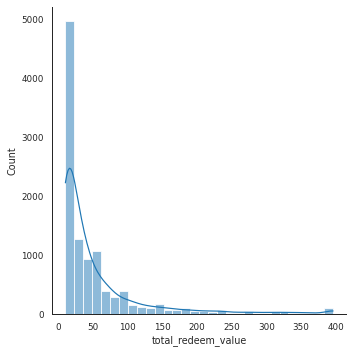

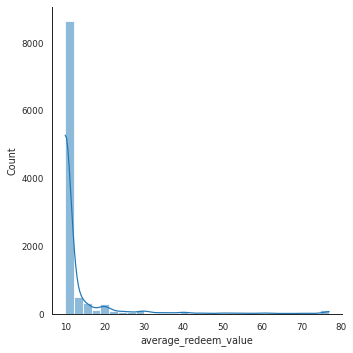

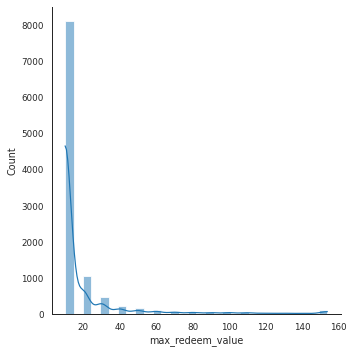

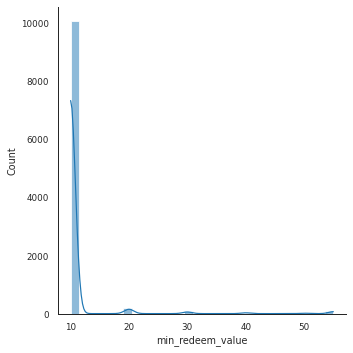

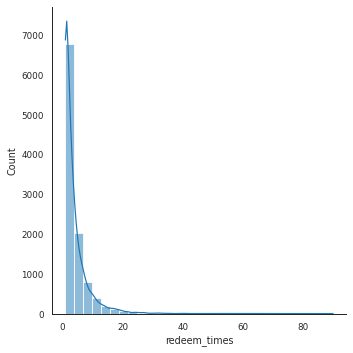

In [34]:
sns.displot(data=vou_redeem, x="total_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=vou_redeem, x="average_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=vou_redeem, x="max_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=vou_redeem, x="min_redeem_value", kind="hist", kde=True, bins=30)
sns.displot(data=vou_redeem, x="redeem_times", kind="hist", kde=True, bins=30)

# VOU recency.

In [41]:
vou_recency = sql2df("gcp-wow-rwds-ai-beh-seg-dev", 
                     """
                     select * from gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.redemption_vou_recency
                     where MOD(ABS(FARM_FINGERPRINT(crn)), 500) = 250;
                     """)
vou_recency.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


recency
count  10476.000000
mean      98.979763
std       90.708724
min        0.000000
25%       27.000000
50%       71.000000
75%      141.000000
max      364.000000

In [43]:
sns.set_context({"figure.figsize":(10,10)})
sns.set_style('white')
sns.set_context("paper")
sns.displot(data=vou_recency, x="recency", kind="hist", kde=True, bins=30)
plt.show()